In [1]:
import os 
import cv2
import sys  
import numpy as np 
import pandas as pd
import tensorflow as tf 
import albumentations as at 
import matplotlib.pyplot as plt  

In [58]:
from IPython.display import SVG 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import to_categorical, Sequence, model_to_dot 
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.layers import Activation , Conv2D, MaxPooling2D, Dense, Flatten, Input, GlobalAveragePooling2D, Dropout, Concatenate

In [26]:
def get_show_shape(images):
    for i in range(len(images)):
        print(f"{images[i].shape}")

def get_show_plot(images, labels, ncols=15):
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches(12, 12)
    
    for i in range(ncols):
        ax = axes[i//5, i%5] 
        ax.imshow(images[i])
        ax.axis("off")
        ax.set_title(str(labels[i]))
            

    plt.tight_layout()
    plt.show()

def get_show_version(): 
    print(f"numpy : {np.__version__}")
    print(f"tensorflow : {tf.__version__}")
    print(f"python : {sys.version}")


In [20]:
get_show_version()

numpy : 1.21.6
tensorflow : 2.8.2
python : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


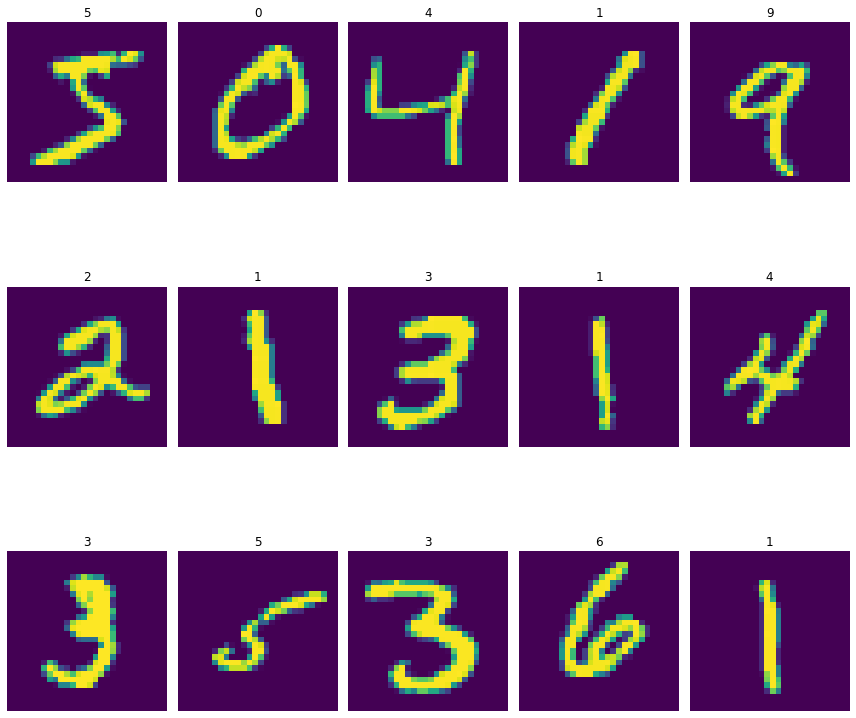

In [27]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
get_show_shape([x_train, y_train, x_test, y_test])
get_show_plot(x_train[:15], y_train[:15], ncols=15)

In [39]:
def get_preprocessed_image(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels 

def get_preprocessed_one_hot_encoding(images, labels):
    images, labels = get_preprocessed_image(images, labels)
    oh_labels = to_categorical(labels)
    return images, labels 

def get_train_test_valid_split(train_images, train_labels, test_images, test_labels):
    train_images, train_oh_labels = get_preprocessed_one_hot_encoding(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_one_hot_encoding(test_images, test_labels)

    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=0.15, random_state=2022)

    return (tr_images, tr_oh_labels),(val_images, val_oh_labels), (test_images, test_labels) 

def get_even_separate_odd(labels):
    labels_odd = []
    for y in range (labels):
        if y % 2 == 0 : 
            labels_odd.append(0)
        else: 
            labels_odd.append(1)
    labels_odd = np.array(labels_odd)

    return labels_odd

In [35]:
y_train_odd = [] 
for y in y_train:
    if y % 2 == 0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [37]:
y_test_odd = []
for y in y_test:
    if y % 2 == 0:
        y_test_odd.append(0)
    else:
        y_test_odd.append(1)

y_test_odd = np.array(y_test_odd)
y_test_odd.shape
print(y_test[:10])
print(y_test_odd[:10])


[7 2 1 0 4 1 4 9 5 9]
[1 0 1 0 0 1 0 1 1 1]


In [40]:
x_train = x_train / 255.0
x_test = x_test / 255.0 

x_train_in = tf.expand_dims(x_train, -1)
x_test_in = tf.expand_dims(x_test, -1)
get_show_shape([x_train_in, x_test_in])

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [52]:
def set_create_model():
    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(input_tensor)
    x = Activation("relu")(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    
    flat_x = Flatten()(input_tensor)
    x = Concatenate()([x, flat_x])
    output = Dense(10, activation="softmax", name="output")(x)

    model = Model(inputs = input_tensor, outputs=output)

    return model

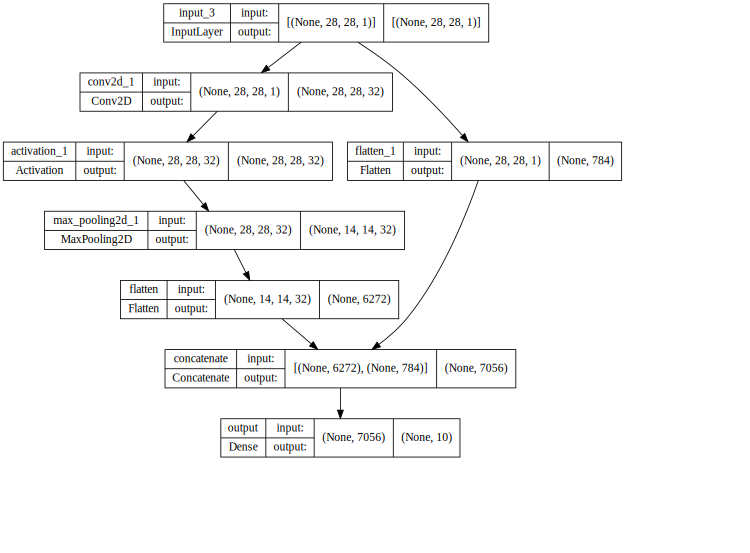

In [53]:
model = set_create_model()
SVG(model_to_dot(model, show_shapes=True, dpi=60).create(prog="dot", format="svg"))

In [60]:
model.compile(optimizer=Adam(lr=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train_in, y_train,epochs=20, 
                    validation_data=(x_test_in, y_test))
val_loss, val_acc = model.evaluate(x_test_in, y_test)
print(val_loss, val_acc)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1875/1875 [==============================] - 35s 18ms/step - loss: 0.2106 - accuracy: 0.9395 - val_loss: 0.0872 - val_accuracy: 0.9734
Epoch 2/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0794 - accuracy: 0.9765 - val_loss: 0.0753 - val_accuracy: 0.9769
Epoch 3/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0596 - accuracy: 0.9820 - val_loss: 0.0567 - val_accuracy: 0.9812
Epoch 4/20
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0484 - accuracy: 0.9855 - val_loss: 0.0598 - val_accuracy: 0.9809
Epoch 5/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0416 - accuracy: 0.9874 - val_loss: 0.0628 - val_accuracy: 0.9811
Epoch 6/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0341 - accuracy: 0.9892 - val_loss: 0.0693 - val_accuracy: 0.9794
Epoch 7/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0293 - accuracy: 0.9906 - val_loss: 0.0548 - val_accura